In [52]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree, svm
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from ucimlrepo import fetch_ucirepo

In [53]:
# data
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
obesity_f = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
obesity_t = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets 

class_names = [
    'Insufficient_Weight',
    'Normal_Weight',
    'Overweight_Level_I',
    'Overweight_Level_II',
    'Obesity_Type_I',
    'Obesity_Type_II',
    'Obesity_Type_III'
]

## Preliminary dataset exploration

In [54]:
obesity_f.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation


In [55]:
obesity_f.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [56]:
obesity_f.info()
obesity_t.info()
obesity_t['NObeyesdad'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

In [57]:
#missing values check
print(obesity_f.isna().any().any())
missing_rows = obesity_f[obesity_f.isna().any(axis=1)]
print(missing_rows)

False
Empty DataFrame
Columns: [Gender, Age, Height, Weight, family_history_with_overweight, FAVC, FCVC, NCP, CAEC, SMOKE, CH2O, SCC, FAF, TUE, CALC, MTRANS]
Index: []


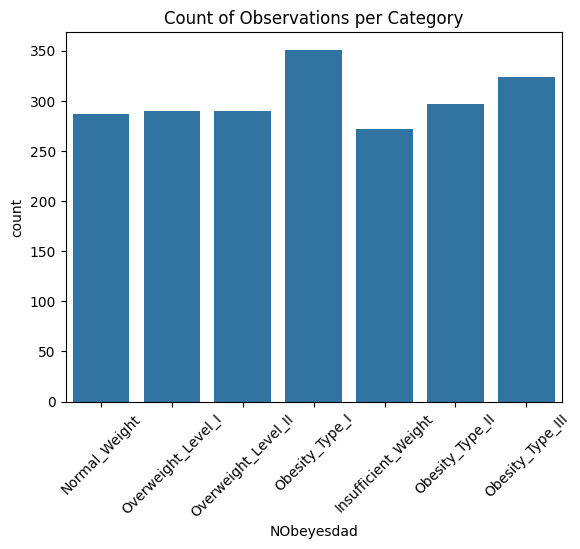

In [58]:
sns.countplot(x='NObeyesdad', data=obesity_t)
plt.title("Count of Observations per Category")
plt.xticks(rotation=45)
plt.show()

Dataset is free of missing values and target variable distribution is quite uniform, feature variables also don't demonstrate any false values. Thus it is appropriate for model training.

## Model training and testing
3 algorithms will be tested to determine which one performes the best: k-means, SVM and random forest. 


In [59]:
#encoding
obesity_f_c = obesity_f.copy()
obesity_t_c = obesity_t.copy()
le = LabelEncoder()
obesity_f_c['Gender'] = le.fit_transform(obesity_f_c['Gender'])
obesity_f_c['FAVC'] = le.fit_transform(obesity_f_c['FAVC'])
obesity_f_c['family_history_with_overweight'] = le.fit_transform(obesity_f_c['family_history_with_overweight'])
obesity_f_c['SMOKE'] = le.fit_transform(obesity_f_c['SMOKE'])
obesity_f_c['SCC'] = le.fit_transform(obesity_f_c['SCC'])
obesity_f_c['MTRANS'] = le.fit_transform(obesity_f_c['MTRANS'])
encoder = OrdinalEncoder(categories=[['no', 'Sometimes', 'Frequently','Always']])
obesity_f_c['CAEC'] = encoder.fit_transform(obesity_f_c[['CAEC']])
obesity_f_c['CALC'] = encoder.fit_transform(obesity_f_c[['CALC']])
encoder = OrdinalEncoder(categories=[['Insufficient_Weight','Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II','Obesity_Type_I', 'Obesity_Type_II','Obesity_Type_III']])
obesity_t_c['NObeyesdad']=encoder.fit_transform(obesity_t_c[['NObeyesdad']])

print(obesity_f_c.head())
print(obesity_t_c.head())


   Gender   Age  Height  Weight  family_history_with_overweight  FAVC  FCVC  \
0       0  21.0    1.62    64.0                               1     0   2.0   
1       0  21.0    1.52    56.0                               1     0   3.0   
2       1  23.0    1.80    77.0                               1     0   2.0   
3       1  27.0    1.80    87.0                               0     0   3.0   
4       1  22.0    1.78    89.8                               0     0   2.0   

   NCP  CAEC  SMOKE  CH2O  SCC  FAF  TUE  CALC  MTRANS  
0  3.0   1.0      0   2.0    0  0.0  1.0   0.0       3  
1  3.0   1.0      1   3.0    1  3.0  0.0   1.0       3  
2  3.0   1.0      0   2.0    0  2.0  1.0   2.0       3  
3  3.0   1.0      0   2.0    0  2.0  0.0   2.0       4  
4  1.0   1.0      0   2.0    0  0.0  0.0   1.0       3  
   NObeyesdad
0         1.0
1         1.0
2         1.0
3         2.0
4         3.0


In [60]:
def model_comp (model,X_train, X_test, y_train, y_test ):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    y_test_labels = [class_names[int(i)] for i in y_test]
    y_pred_labels = [class_names[int(i)] for i in y_pred]
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(
    y_test_labels,
    y_pred_labels
    ))
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

f_names=['Gender','Age', 'Height','family_history_with_overweight','FAVC','FCVC','NCP','CAEC','SMOKE','CH2O','SCC','FAF','TUE','CALC','MTRANS']
X = obesity_f_c[f_names] 
y = obesity_t_c['NObeyesdad']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

Accuracy: 0.78
                     precision    recall  f1-score   support

Insufficient_Weight       0.76      0.88      0.81        40
      Normal_Weight       0.84      0.34      0.49        61
     Obesity_Type_I       0.77      0.86      0.81        76
    Obesity_Type_II       0.85      0.94      0.89        70
   Obesity_Type_III       0.91      1.00      0.96        64
 Overweight_Level_I       0.73      0.67      0.70        57
Overweight_Level_II       0.63      0.78      0.70        55

           accuracy                           0.78       423
          macro avg       0.79      0.78      0.77       423
       weighted avg       0.79      0.78      0.77       423



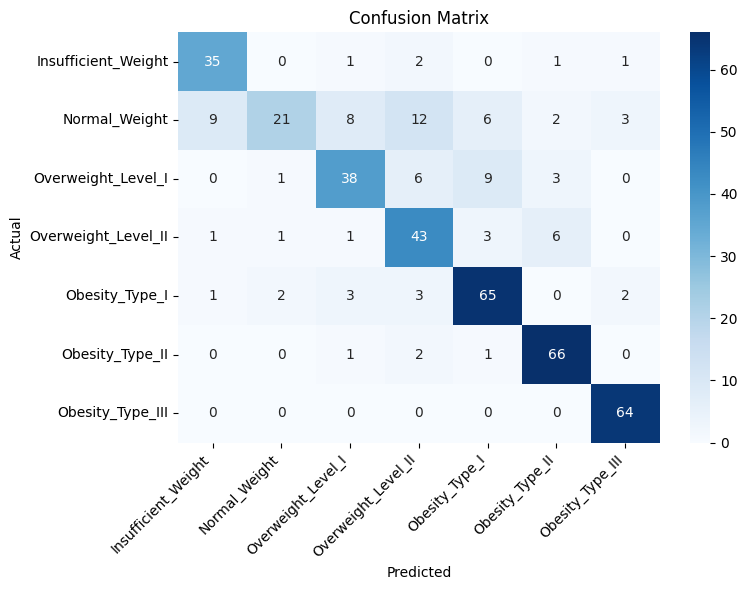

In [61]:
model_kn = KNeighborsClassifier(n_neighbors=2,weights='distance')
model_comp(model_kn,X_train, X_test, y_train, y_test)

Accuracy: 0.48
                     precision    recall  f1-score   support

Insufficient_Weight       0.29      0.82      0.43        40
      Normal_Weight       0.47      0.11      0.18        61
     Obesity_Type_I       0.39      0.74      0.51        76
    Obesity_Type_II       0.67      0.71      0.69        70
   Obesity_Type_III       0.84      0.84      0.84        64
 Overweight_Level_I       0.33      0.05      0.09        57
Overweight_Level_II       0.40      0.04      0.07        55

           accuracy                           0.48       423
          macro avg       0.49      0.47      0.40       423
       weighted avg       0.50      0.48      0.42       423



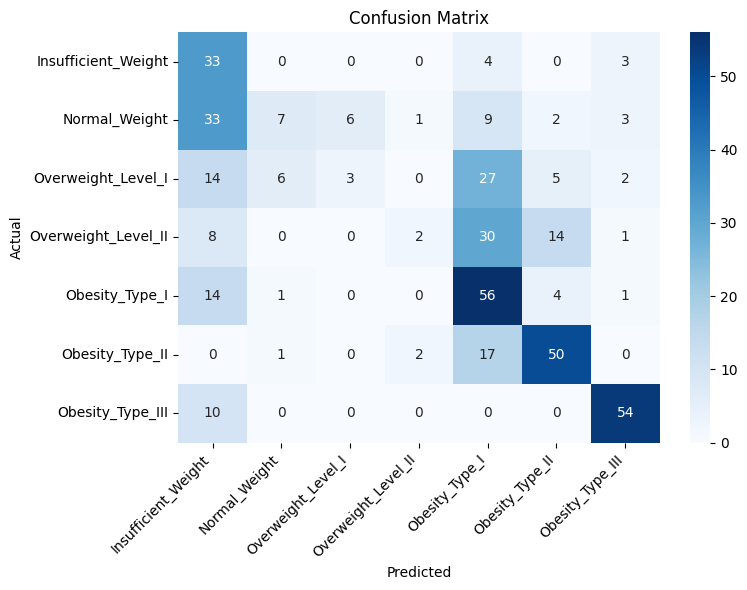

In [62]:
model_svm = svm.SVC(kernel='poly')
model_comp(model_svm,X_train, X_test, y_train, y_test)

Accuracy: 0.88
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.85      0.88        40
      Normal_Weight       0.71      0.84      0.77        61
     Obesity_Type_I       0.89      0.89      0.89        76
    Obesity_Type_II       0.93      1.00      0.97        70
   Obesity_Type_III       1.00      1.00      1.00        64
 Overweight_Level_I       0.90      0.79      0.84        57
Overweight_Level_II       0.86      0.76      0.81        55

           accuracy                           0.88       423
          macro avg       0.89      0.88      0.88       423
       weighted avg       0.89      0.88      0.88       423



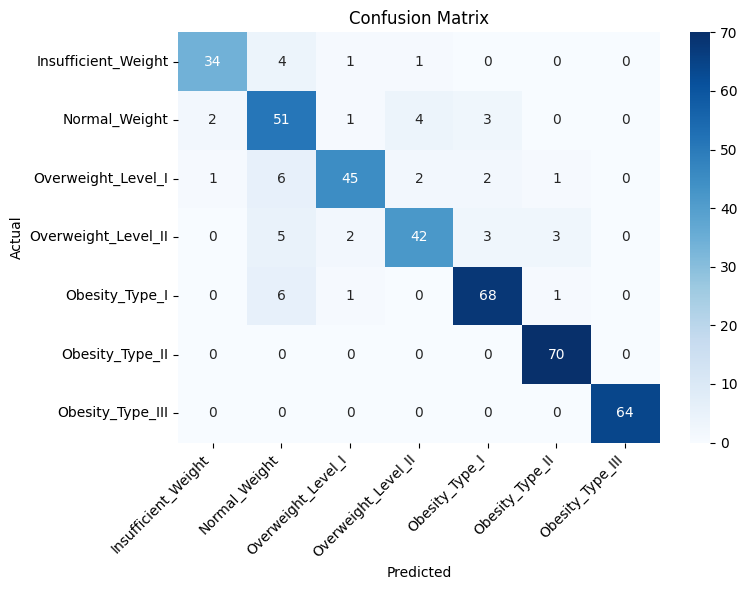

In [63]:
model_rf = RandomForestClassifier(n_estimators=100,bootstrap=True, min_samples_split=10,random_state=11)
model_comp(model_rf,X_train, X_test, y_train, y_test)

If judging just by accuracy, SVM is the only model out of three which performes very poorly, having accuracy of 48%. K-neighbours classifier shows quite satisfying result (78%), but also doesn't reach the defined goal of 80%. Random forest shows the best performance - 88%.   
Changing parameters in all 3 cases didn't do much to improve results, all gains where in range 1-2%.  
In case of obesity prediction, missing the problem could be potentially more costly than labeling person with normal weight as obese. Thus recall is more important than precision. F1 is also valuable as integral factor. 

- It could be seen that SVM completely misses overweight cases, labeling it either as insufficient weight or obesity. From that performance could be concluded that SVM is not suitable model for that kind of task.
- K-neighbours classifier demonstrates worst scores for normal weight class, often labeling it as overweight. As well, distinguishing overweight classes is also not perfect.
- Random forest performance is very good, it struggles in some cases of normal weight/overweight.

Judging from this picture, random forest is algorithm which should be applied in that case. K-neighbours classifier is also appropriate and could be used with some adjustments or when there is no way to apply random forest. SVM is not appropritate for that problem, since its main advantage - operating in highly-dimensional space is not used. 

                           Feature  Importance
1                              Age    0.144826
5                             FCVC    0.138076
2                           Height    0.112881
6                              NCP    0.086409
12                             TUE    0.081755
0                           Gender    0.070454
11                             FAF    0.069376
9                             CH2O    0.068302
3   family_history_with_overweight    0.056362
7                             CAEC    0.053038
13                            CALC    0.049790
14                          MTRANS    0.032595
4                             FAVC    0.023820
10                             SCC    0.010386
8                            SMOKE    0.001930


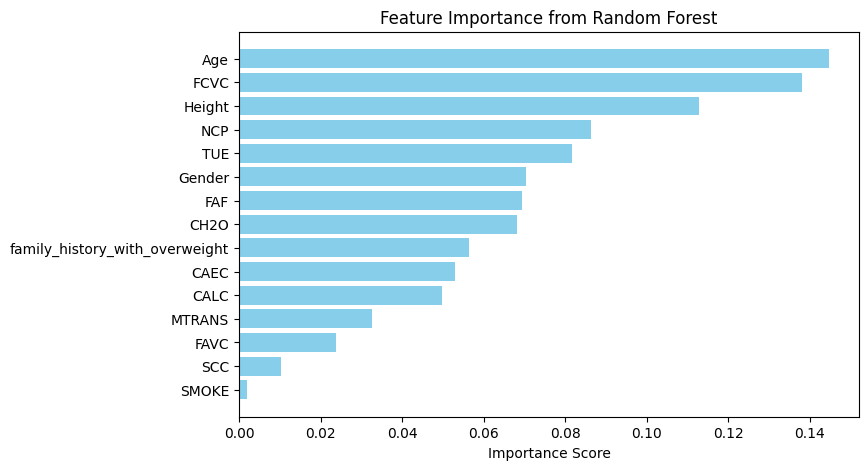

In [64]:
importances = model_rf.feature_importances_
importance_df = pd.DataFrame({'Feature': f_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

## Conclusions
__Interpretation:__  
- The most appropriate model for the given classification task is random forest classifier. This model demonstrates adequate performance for all categories of target variable given in the dataset. Model tends to predict more severe obesity types better, whilst separating overweight levels from normal weight is harder.
  
- As could be seen, age is the most important variable in prediction process which reinforces the idea that people tend to gain more weight with age. Eating vegetables also has strong impact on weight, reflecting importance of healthy diet. Height is expected as an important feature - tall people weight more. Last 2 of the 5 most importand features are amount of meals per day and use of gadgets, last most probably reflecting sedentary lifestyle.  
To conclude, people should take more care about their weight as they grow older, adhere to balanced diet with plenty of vegetables included, eat less food and have more physical activity. 